### Predicting Winner in League of Legends Ranked Matches

Datasets:

Ranked Games: https://www.kaggle.com/datasnaek/league-of-legends

High ELO Ranked Games: https://www.kaggle.com/gyejr95/league-of-legends-challenger-ranked-games2020


This project uses a dataset of ranked matches from League of Legends to predict the winner in ranked matches. LoL is a multiplayer online battle arena game where two teams of 5 compete against each other to destroy the other team's Nexus (a structure located in each team's base). Ranked matches are games where teams compete to climb the leaderboard and ranking tiers within the game (ranges from Iron to Challenger, 9 total tiers).

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

### Predicting Winner in Ranked Matches

In [2]:
matches = pd.read_csv("games.csv")
matches = matches.drop(columns=["gameId", "creationTime", "seasonId"])
matches

,gameDuration,winner,firstBlood,firstTower,firstInhibitor,firstBaron,firstDragon,firstRiftHerald,t1_champ1id,t1_champ1_sum1,...,t2_towerKills,t2_inhibitorKills,t2_baronKills,t2_dragonKills,t2_riftHeraldKills,t2_ban1,t2_ban2,t2_ban3,t2_ban4,t2_ban5
0,1949,1,2,1,1,1,1,2,8,12,...,5,0,0,1,1,114,67,43,16,51
1,1851,1,1,1,1,0,1,1,119,7,...,2,0,0,0,0,11,67,238,51,420
2,1493,1,2,1,1,1,2,0,18,4,...,2,0,0,1,0,157,238,121,57,28
3,1758,1,1,1,1,1,1,0,57,4,...,0,0,0,0,0,164,18,141,40,51
4,2094,1,2,1,1,1,1,0,19,4,...,3,0,0,1,0,86,11,201,122,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51485,1944,2,1,2,2,0,2,0,19,12,...,10,2,0,4,0,55,-1,90,238,157
51486,3304,2,1,1,2,2,2,2,90,4,...,11,7,4,4,1,157,55,119,154,105
51487,2156,2,2,2,2,0,1,0,141,11,...,10,2,0,2,0,113,122,53,11,157
51488,1475,2,2,2,2,0,2,0,121,11,...,11,3,0,1,0,154,39,51,90,114


<AxesSubplot:>

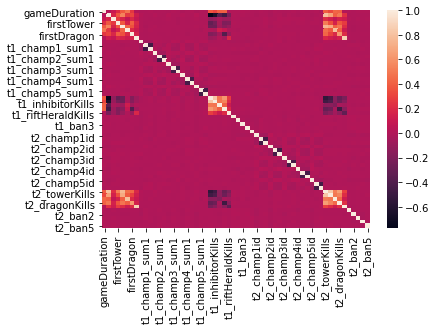

In [3]:
sns.heatmap(matches.corr())

The correlation heatmap is very busy since there are a lot of variables. This is because variables like champ and ban is unique to each individual player (5v5, 10 players total). To reduce the number of features, we can run a principal component analysis before we train a model.

In [4]:
from sklearn.preprocessing import StandardScaler

#separating features
features = matches.drop(columns=["winner"])
X = features.values
#separating target
y = matches[["winner"]].values
# Standardizing the features
X = StandardScaler().fit_transform(X)

In [5]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X)
pca_df = pd.DataFrame(data=principalComponents, columns = ["pca1", "pca2"])

In [6]:
matches_df = pd.concat([pca_df, matches[['winner']]], axis = 1)
matches_df

,pca1,pca2,winner
0,-1.386306,1.684133,1
1,-3.230642,0.683151,1
2,-1.334954,-0.186023,1
3,-2.829245,0.624924,1
4,-2.086107,1.360117,1
...,...,...,...
51485,2.370478,-1.326852,2
51486,5.286601,4.508812,2
51487,1.675437,-1.225453,2
51488,2.233871,-2.122349,2


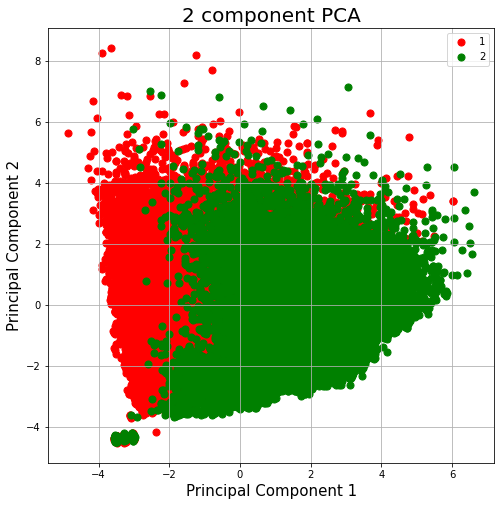

In [7]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)

ax.set_title('2 component PCA', fontsize = 20)
targets = [1,2]
colors = ['r', 'g', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = matches_df['winner'] == target
    ax.scatter(matches_df.loc[indicesToKeep, 'pca1'],
               matches_df.loc[indicesToKeep, 'pca2'],
               c = color,
               s = 50)
ax.legend(targets)
ax.grid()

In [8]:
pca.explained_variance_ratio_

array([0.09486616, 0.05159778])

Running a PCA shows us that reducing the number of features may not be the best approach. The explained variance ration is a metric used to measure how much of the data k number of principal componenets can explain. In this case, the top 2 features with the "best" principal components only account for a tiny fraction of the data. This makes sense since there are, essentially, an infinite number of variables that can decide the outcome of a LoL match. With our limited data, it will be difficult to predict winners but we should move forward with keeping all features for our model.

### Decision Tree for Predicting Winner

A decision tree tries to make a prediction (based on features) by making decisions through splitting a node into two or more sub-nodes. In this case, the decision tree will use all available features (i.e. gameDuration, firstBlood, etc.) to make a prediction on the target, winner. The algorithm will begin with an original set as the root node. This will be the entire dataset of features. After each iteration, the algorithm goes through unused features of this set and calculates entropy and information gain of the feature, then splits the feature with the smallest entropy or largest information gain to produce a subset. The algorithm reiterates this process on each subset and goes through features that were not selected until a decision is made.


Source: https://towardsdatascience.com/a-dive-into-decision-trees-a128923c9298

In [9]:
#the code below takes a fitted tree model and plots a visual representation of the algorithm's decisions
import graphviz
import matplotlib.pyplot as plt
import pydotplus
import matplotlib.image as mpimg
import io
from sklearn.tree import export_graphviz

def draw_tree(tree):
    dot_data = export_graphviz(tree,
                               out_file=None,
                               feature_names=features, 
                               class_names=["Winner 1", "Winner 2"],
                               filled=True,
                               rounded=True,
                               special_characters=True,
                               proportion = True)
    
    graph = graphviz.Source(dot_data)
    graph.format = "png"
    graph.render("tree",view=True)
    plt.figure(figsize=(50,50))
    img = mpimg.imread("tree.png")
    imgplot = plt.imshow(img)

    plt.show()

In [10]:
from sklearn.model_selection import train_test_split

features = matches.drop(columns=["winner"]).columns #later used in tree visual
#separating features
X = matches.drop(columns=["winner"])
#separating target
y = matches[["winner"]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [11]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn import metrics

### Determining Best Depth using ROC AUC
One of the parameters of a decision tree is max_depth, which defines the number of levels the tree will iterate through to arrive at a decision. The ROC AUC measures the performance of the model. Higher the AUC, the better the model is at predicting winner 1 classes as winner 1 and winner 2 classes as winner 2. The table below shows that the highest mean roc auc is at depths=5, so we can move forward with training a decision tree with depths=5.

In [12]:
depths = np.arange(2,10) # define the depths
results = [] # create an empty data frame for our results

for depth in depths:
    best_depth_tree = DecisionTreeClassifier(max_depth = depth) # creating an instance of a decision tree
    results.append(cross_val_score(best_depth_tree, X, y, scoring="roc_auc", # getting the cv accuracy metric for the tree at each depth
                cv=3).mean())
    
test = pd.DataFrame({'depths':depths, 'mean_roc_auc':results})
test.sort_values("mean_roc_auc", ascending=False)

,depths,mean_roc_auc
3,5,0.995305
4,6,0.995184
5,7,0.994204
2,4,0.993607
6,8,0.990130
1,3,0.988127
7,9,0.985063
0,2,0.973918


### Fitting a Decision Tree

In [13]:
matches_win_tree = DecisionTreeClassifier(max_depth=5)
matches_win_tree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5)

### Confusion Matrix

The confusion matrix below gives us the following information about the performance of the model:
   - 8359 matches were correctly classified as winner=1
   - 343 matches were incorrectly classified as winner=1
   - 8031 matches were correctly classified as winner=2
   - 259 matches were incorrectly classified as winner=2
   - In total, 16,992 matches were tested using the trained decision tree
   - 16,390 matches were correctly classified
   - 602 matches were incorrectly classified

In [14]:
simple_predictions = matches_win_tree.predict(X_test)
print(metrics.confusion_matrix(y_test, simple_predictions))

[[8359  259]
 [ 343 8031]]


### Accuracy Score

The accuracy score below tells us that the winning team in 96% of matches were correctly classified out of the total number of matches used in testing.

In [15]:
print(metrics.accuracy_score(y_test, simple_predictions))

0.9645715630885122


### Feature Importances

The dictionary below shows us the distribution of feature importances in the dataset. Although we were not able to use PCA to reduce the number of dimensions, we can clearly see that the decision tree was able to distinguish the importance of certain features over others. We see that towerKills makes up about 95% of the feature importances distribution in this decision tree. This is reasonable to believe since each team must destroy at least 3 outer towers before being able to attach the Nexus to win the match.

In [16]:
x = dict(zip(
    features,
    matches_win_tree.feature_importances_
))

{k: v for k, v in sorted(x.items(), key=lambda item: item[1], reverse= True)}

{'t2_towerKills': 0.718938630922344,
 't1_towerKills': 0.23479598504535143,
 't2_inhibitorKills': 0.017947397524946517,
 't1_inhibitorKills': 0.015206793765628219,
 'firstInhibitor': 0.011039767113063372,
 'firstBlood': 0.0011941069783556043,
 't2_dragonKills': 0.0004406189628114218,
 't1_champ3id': 0.00012609616408118678,
 't1_champ2id': 0.00012574477182879102,
 't2_champ2id': 0.00012493103902718686,
 't1_champ4id': 5.9927712562167315e-05,
 'gameDuration': 0.0,
 'firstTower': 0.0,
 'firstBaron': 0.0,
 'firstDragon': 0.0,
 'firstRiftHerald': 0.0,
 't1_champ1id': 0.0,
 't1_champ1_sum1': 0.0,
 't1_champ1_sum2': 0.0,
 't1_champ2_sum1': 0.0,
 't1_champ2_sum2': 0.0,
 't1_champ3_sum1': 0.0,
 't1_champ3_sum2': 0.0,
 't1_champ4_sum1': 0.0,
 't1_champ4_sum2': 0.0,
 't1_champ5id': 0.0,
 't1_champ5_sum1': 0.0,
 't1_champ5_sum2': 0.0,
 't1_baronKills': 0.0,
 't1_dragonKills': 0.0,
 't1_riftHeraldKills': 0.0,
 't1_ban1': 0.0,
 't1_ban2': 0.0,
 't1_ban3': 0.0,
 't1_ban4': 0.0,
 't1_ban5': 0.0,
 't2_

### Decision Tree Visualization

The tree below is a visualization of how the model iterates through decisions based on features. As mentioned before, towerKills is clearly the most important feature, since the decision tree seems to rely on it to make a decision. For example, the root node starts by classifying winning team as 1 if towerKills for team 2 is less than or equal to 6.5 and winning team as 2 if towerKills for team 2 is more than 6.5. One thing to highlight here is that at depth=4, there are a few cases where champid is used to make a decision. This is interesting because certain champions in the game scale better/have higher win % overall, so the team who uses these champions may have a higher probability at winning.

LoL Champion win % site:https://champion.gg/statistics/

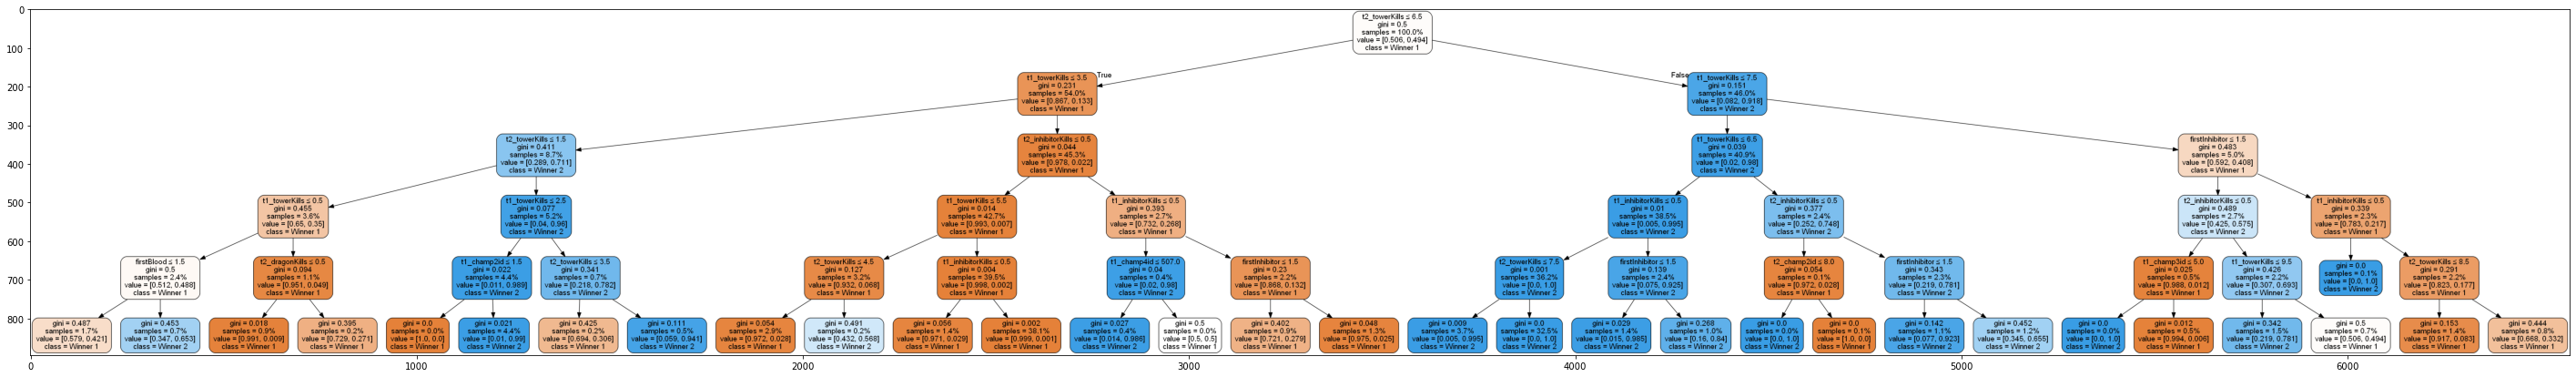

In [17]:
#double click image to zoom in or open tree.png in repository
draw_tree(matches_win_tree)

### Final Note

Overall, the decision tree performed extremely well. However, we must keep in mind that the model would be able to perform well only within the dimensions of the available features in this dataset. As mentioned before, there are countless numbers of variables that could affect the outcome of a match, thus, this model is limited within the context of this project. Also, the gini impurity measure is high in some decisions (i.e. .5 in root node) and low in others. This measure is the probability of misclassifying a winning team in each decision nodes. This is something to keep in mind when determining how well the model can perform.